## Xingyu Zhang
## Assignment 12
## 11/21/2021

### 2. Grade
- **Readability: 2.5/3** Nice setup it was clear and easy to follow. I subtracted 0.5 because you didn't answer all the questions in the assignment discussing how your forecast has evolved over time and how and why you generated it the way you did this week.  
- **Style: 3/3**  looks good. 
- **Code: 2.5/3** Wow I really like the EOF analysis that you added! Thats very cool.  Overall your code looks good and I like your function. I subtracted 0.5 because not all the data needed to run this is included in the data folder so I couldn't get it all to run. 

this iPython Notebook uses linear regression model to predict the next two weeks' streamflow at 09506000 base station.
The results are 134.0, and 117.5 respectively.

   1.import package

In [1]:
#%%
### For Window's Users
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import fiona
import contextily as ctx
import xarray as xr
import shapely
from shapely.geometry import Point
from netCDF4 import Dataset
import datetime
from sklearn.linear_model import LinearRegression




# %%

plot the study region

In [2]:
# Read USGS WBD file
file = os.path.join('..', 'data/WBD_15_HU2_GDB', 'WBD_15_HU2_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

# Read Major River file
file = os.path.join('..', 'data/Major Rivers', 'Major Rivers.shp')
rivers = gpd.read_file(file)
rivers_project   = rivers.to_crs(HUC6.crs)
rivers_verde_project = rivers_project[rivers_project['NAME'] == 'Verde River']

# Create streamflow gauge point
point_list = np.array([[-111.7891667, 34.44833333]])
point_geom = [Point(xy) for xy in point_list]
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'], crs=HUC6.crs)

# Plot study basin
fig, ax = plt.subplots(figsize=(5, 5))
point_df.loc[[0]].plot(ax=ax, color='red', marker='*', markersize=50, label='Streamflow Gauge 09506000')
rivers_verde_project.plot(ax=ax, color='blue', label='Verde River')
HUC6.boundary.plot(ax=ax, color=None, 
                   edgecolor='black', linewidth=1, label='HUC6 watersheds')
ctx.add_basemap(ax, crs=HUC6.crs, alpha=0.7)

ax.set(title='Study region', xlabel='Longitude', ylabel='Latitude')
ax.legend(fontsize=9, frameon=False)
plt.show()
#fig.savefig('studyregion.jpg', dpi=400)


DriverError: ../data/WBD_15_HU2_GDB/WBD_15_HU2_GDB.gdb: No such file or directory

2. import data and merge into one dataframe.\
 The dataset I use are streamflow at 09506000 base station, NCEP reanalysis precipitation rate is station surrounding region.\
 The temportal range of dataset are 01/01/2020 to 11/19/2021
 

In [3]:
## Insert flow data
flow_url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb" \
           "&site_no=09506000&referred_module=sw" \
           "&period=&begin_date=2020-01-01&end_date=2021-11-17"
flow_data = pd.read_table(flow_url, sep='\t', skiprows=30,
                          names=['agency_cd', 'site_no', 'datetime', 'flow',
                                 'code'], parse_dates=['datetime'],
                          index_col=['datetime'])
flow_data['month'] = pd.DatetimeIndex(flow_data.index).month
flow_data['day'] = pd.DatetimeIndex(flow_data.index).day
flow_data['year'] = pd.DatetimeIndex(flow_data.index).year
# %%
# Read in NetCDF Precipitation Data
precip_path = os.path.join('..', 'data', 'Hierarchical_Data',
                           'X70.176.71.70.323.21.41.53.nc')
precip = xr.open_dataset(precip_path)
precip

# Find size of NetCDF precip data

precip['prate']['lat'].size
precip['prate']['lon'].size
precip["prate"]["time"].size

# Extract single point, convert it to dataframe to make time series
# Extract years, days, months from datetime index to allow for resampling
# Index 0,0 closest to stream gauge

point_precip = precip["prate"]
precip_df = point_precip.to_dataframe()
precip_df = precip_df.groupby('time').mean()
precip_df['year'] = pd.DatetimeIndex(precip_df.index).year
precip_df['month'] = pd.DatetimeIndex(precip_df.index).month
precip_df['day'] = pd.DatetimeIndex(precip_df.index).day
precip_df.drop(precip_df[precip_df['year'] < 2020].index, inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: b'/Users/laura/Documents/HAS_Tools/Fall21/HomeworkGrading/homework/homework-xingyuzhang95/data/Hierarchical_Data/X70.176.71.70.323.21.41.53.nc'

In [49]:
point_precip = precip["prate"]
precip_df = point_precip.to_dataframe()
precip_df['prate']

time        lat        lon    
2000-01-01  35.237499  247.500    8.899951e-06
                       249.375    4.249997e-05
            33.332802  247.500    8.998904e-07
                       249.375    2.998859e-07
2000-01-02  35.237499  247.500    5.899998e-05
                                      ...     
2021-11-16  33.332802  249.375    0.000000e+00
2021-11-17  35.237499  247.500    0.000000e+00
                       249.375    0.000000e+00
            33.332802  247.500    0.000000e+00
                       249.375    0.000000e+00
Name: prate, Length: 31968, dtype: float32

 normalize the precipitation and merge data into one dataframe, and show dataframe

In [23]:
# %%
# Regression and forecast
precip_df
flow_data
# Comnbine streamflow, precip, and air temp into one dataframe
flow_data['precip'] = (precip_df['prate']-np.mean(precip_df['prate']))/np.std(precip_df['prate'])
flow_data

,agency_cd,site_no,flow,code,month,day,year,precip
datetime,,,,,,,,
2020-01-01,USGS,9506000,334.0,A,1,1,2020,-0.217413
2020-01-02,USGS,9506000,300.0,A,1,2,2020,-0.195929
2020-01-03,USGS,9506000,279.0,A,1,3,2020,-0.236212
2020-01-04,USGS,9506000,264.0,A,1,4,2020,-0.222784
2020-01-05,USGS,9506000,256.0,A,1,5,2020,-0.236212
...,...,...,...,...,...,...,...,...
2021-11-13,USGS,9506000,146.0,P,11,13,2021,-0.236212
2021-11-14,USGS,9506000,146.0,P,11,14,2021,-0.230841
2021-11-15,USGS,9506000,146.0,P,11,15,2021,-0.236212


In [30]:
def lr_forecast(train):
    '''
    This function forecast the streamflow of next two weeks.

    Parameters:
    "train: the dataframe the used to calculate"

    Output:
    This function returns a print statement and a time series plot
    '''
    
        
    # Build a linear regression model
    model = LinearRegression()
    x = train[['flow_tm1', 'precip']] 
    y = train['flow'].values
    model.fit(x, y)

    # Results of the model
    r_sq = model.score(x, y)
    print('coefficient of determination:', np.round(r_sq, 2))

    # Print the intercept and the slope
    print('intercept:', np.round(model.intercept_, 2))
    print('slope:', np.round(model.coef_, 2))

    # Prediction
    prediction = model.predict(train[['flow_tm1', 'precip']])
    print(" This week mean flow is ", round(prediction[0], 1))
    print(" This week mean flow is ", round(prediction[1], 1))
    #
    # %%
    # Line plot comparison of predicted and observed flows
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(flow_mean.index[1:], flow_mean['flow'][1:], color='blue',
            label='simulated 2 lag')
    ax.plot(flow_mean.index[1:], prediction, color='red', label='obs')
    ax.set(title="Linear regression flow results", xlabel="Time",
        ylabel="Simulation with 2 lag (cfs)",
        yscale='log', ylim=(0, 15000))
    ax.legend()
    fig.set(facecolor='lightgray')
    plt.show()

    fig.savefig('linear_regression.jpg', dpi=300, bbox_inches='tight')
    return


coefficient of determination: 0.64
intercept: 163.25
slope: [3.6000e-01 6.2011e+02]
 This week mean flow is  134.0
 This week mean flow is  117.5


C:\Users\22050\AppData\Local\Temp/ipykernel_14284/3338066479.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(title="Linear regression flow results", xlabel="Time",


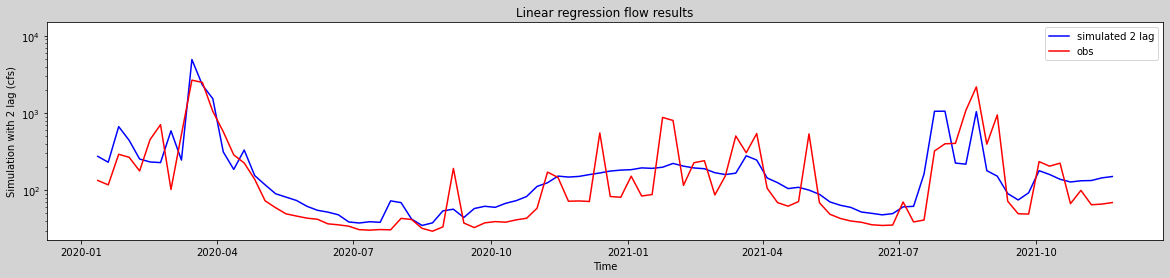

In [31]:
# Build an autoregressive model
flow_mean = flow_data.resample('W').mean()
flow_mean['flow_tm1'] = flow_mean['flow'].shift(1)

# Using the entire flow data
train = flow_mean[1:][['flow', 'flow_tm1' , 'precip']]
lr_forecast(train)


In [36]:
precip_df

,prate,year,month,day
time,,,,
2020-01-01,4.375000e-07,2020,1,1
2020-01-02,9.375000e-07,2020,1,2
2020-01-03,0.000000e+00,2020,1,3
2020-01-04,3.125000e-07,2020,1,4
2020-01-05,0.000000e+00,2020,1,5
...,...,...,...,...
2021-11-13,0.000000e+00,2021,11,13
2021-11-14,1.250000e-07,2021,11,14
2021-11-15,0.000000e+00,2021,11,15


New analysis:\
https://github.com/ajdawson/eofs\
The new analysis I'm interesting (not in the gallary) is Empirical Orthogonal Function (EOF) and Principal component(PC) analysis, it is an analysis the can find the anomoly in spectial and temporal range. The code attached is the EOF analysis of Chinese precipitation\
Becuase the streamflow is a 'point' precipitation, the EOF analysis cannot analysis it very well. 

Also, a EOF analysis sample code attached

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import xarray as xr
from eofs.standard import Eof

In [65]:
point_precip = precip["prate"]
precip_df = point_precip.to_dataframe()
precip_df['prate']
pre = np.array(precip_df['prate']).reshape(2,2,7992)
solver = Eof(pre)
eof = solver.eofsAsCorrelation(neofs=3)
pc = solver.pcs(npcs=3, pcscaling=1)
var = solver.varianceFraction()
print(pc[:,0])

[-0.70710677  0.70710677]


sample code

C:\Users\22050\miniconda3\envs\hastools\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\22050\miniconda3\envs\hastools\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\22050\miniconda3\envs\hastools\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


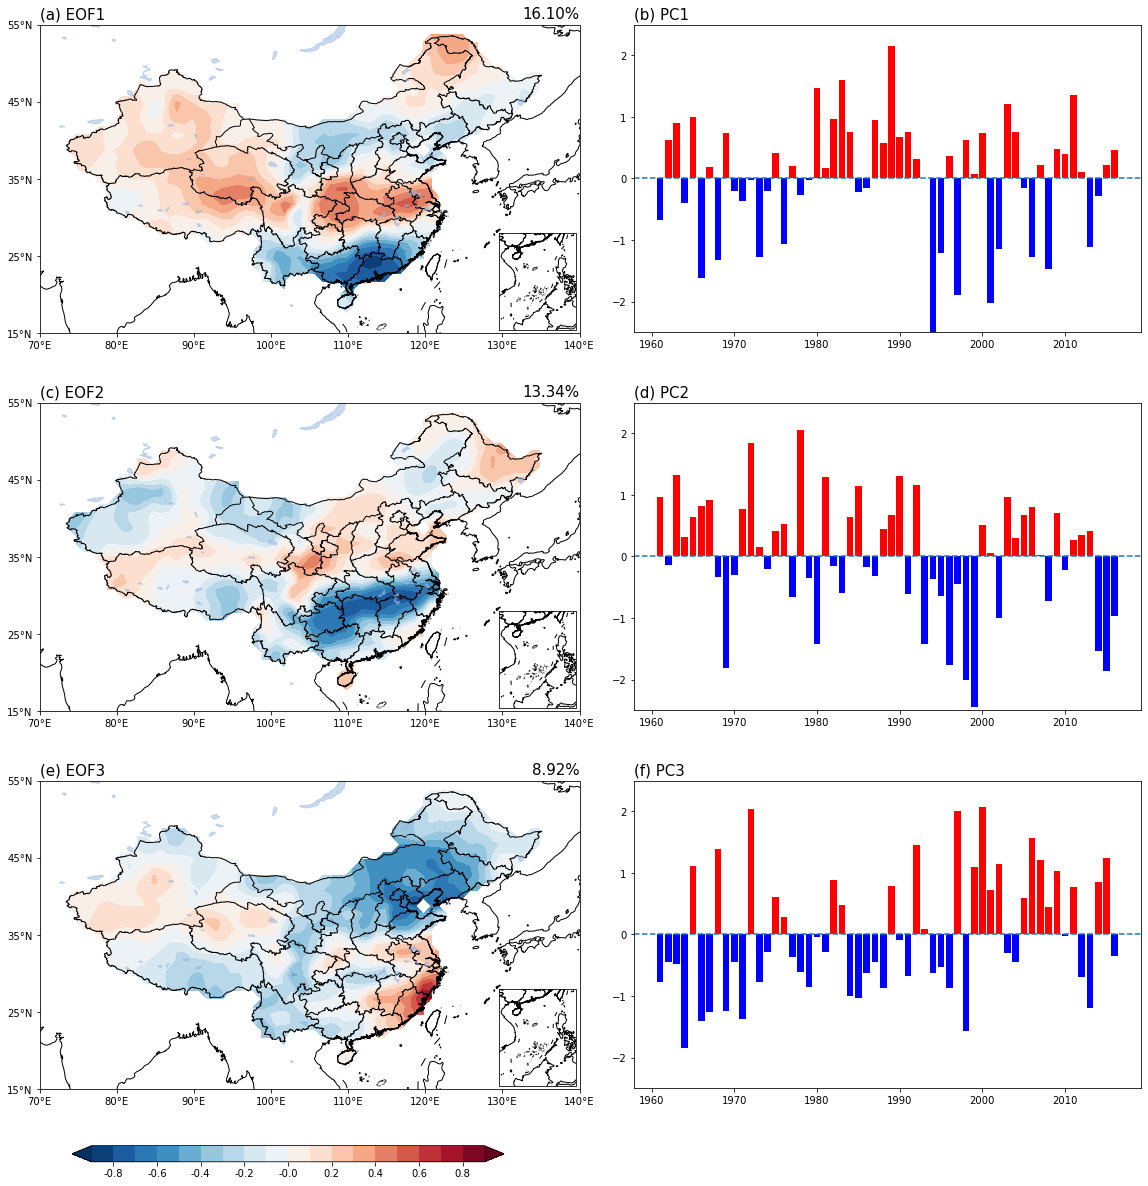

In [63]:


f = xr.open_dataset('./pre.nc')
pre = np.array(f['pre'])
lat = f['lat']
lon = f['lon']
lat = np.array(lat)
coslat = np.cos(np.deg2rad(lat))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(pre, weights=wgts)
eof = solver.eofsAsCorrelation(neofs=3)
pc = solver.pcs(npcs=3, pcscaling=1)
var = solver.varianceFraction()
color1=[]
color2=[]
color3=[]
for i in range(1961,2017):
    if pc[i-1961,0] >=0:
        color1.append('red')
    elif pc[i-1961,0] <0:
        color1.append('blue')
    if pc[i-1961,1] >=0:
        color2.append('red')
    elif pc[i-1961,1] <0:
        color2.append('blue')
    if pc[i-1961,2] >=0:
        color3.append('red')
    elif pc[i-1961,2] <0:
        color3.append('blue')
#%%
fig = plt.figure(figsize=(15,15))
proj = ccrs.PlateCarree(central_longitude=115)
leftlon, rightlon, lowerlat, upperlat = (70,140,15,55)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

fig_ax1 = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.add_feature(cfeature.LAKES, alpha=0.5)
fig_ax1.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)
china = shpreader.Reader('./bou2_4l.dbf').geometries()
fig_ax1.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)
fig_ax1.set_title('(a) EOF1',loc='left',fontsize =15)
fig_ax1.set_title( '%.2f%%' % (var[0]*100),loc='right',fontsize =15)
c1=fig_ax1.contourf(lon,lat, eof[0,:,:], levels=np.arange(-0.9,1.0,0.1), zorder=0, extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

fig_ax2 = fig.add_axes([0.1, 0.45, 0.5, 0.3],projection = proj)
fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.add_feature(cfeature.LAKES, alpha=0.5)
fig_ax2.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)
china = shpreader.Reader('./bou2_4l.dbf').geometries()
fig_ax2.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)
fig_ax2.set_title('(c) EOF2',loc='left',fontsize =15)
fig_ax2.set_title( '%.2f%%' % (var[1]*100),loc='right',fontsize =15)
c2=fig_ax2.contourf(lon,lat, eof[1,:,:], levels=np.arange(-0.9,1.0,0.1), zorder=0, extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

fig_ax3 = fig.add_axes([0.1, 0.1, 0.5, 0.3],projection = proj)
fig_ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
fig_ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax3.add_feature(cfeature.LAKES, alpha=0.5)
fig_ax3.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
fig_ax3.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
fig_ax3.xaxis.set_major_formatter(lon_formatter)
fig_ax3.yaxis.set_major_formatter(lat_formatter)
china = shpreader.Reader('./bou2_4l.dbf').geometries()
fig_ax3.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)
fig_ax3.set_title('(e) EOF3',loc='left',fontsize =15)
fig_ax3.set_title( '%.2f%%' % (var[2]*100),loc='right',fontsize =15)
c3=fig_ax3.contourf(lon,lat, eof[2,:,:], levels=np.arange(-0.9,1.0,0.1), zorder=0, extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

fig_ax11 = fig.add_axes([0.525, 0.08, 0.072, 0.15],projection = proj)
fig_ax11.set_extent([105, 125, 0, 25], crs=ccrs.PlateCarree())
fig_ax11.add_feature(cfeature.COASTLINE.with_scale('50m'))
china = shpreader.Reader('./bou2_4l.dbf').geometries()
fig_ax11.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)

fig_ax22 = fig.add_axes([0.525, 0.43, 0.072, 0.15],projection = proj)
fig_ax22.set_extent([105, 125, 0, 25], crs=ccrs.PlateCarree())
fig_ax22.add_feature(cfeature.COASTLINE.with_scale('50m'))
china = shpreader.Reader('./bou2_4l.dbf').geometries()
fig_ax22.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)

fig_ax33 = fig.add_axes([0.525, 0.78, 0.072, 0.15],projection = proj)
fig_ax33.set_extent([105, 125, 0, 25], crs=ccrs.PlateCarree())
fig_ax33.add_feature(cfeature.COASTLINE.with_scale('50m'))
china = shpreader.Reader('./bou2_4l.dbf').geometries()
fig_ax33.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)

cbposition=fig.add_axes([0.13, 0.04, 0.4, 0.015])
fig.colorbar(c1,cax=cbposition,orientation='horizontal',format='%.1f',)

fig_ax4 = fig.add_axes([0.65, 0.808, 0.47, 0.285])
fig_ax4.set_title('(b) PC1',loc='left',fontsize = 15)
fig_ax4.set_ylim(-2.5,2.5)
fig_ax4.axhline(0,linestyle="--")
fig_ax4.bar(np.arange(1961,2017,1),pc[:,0],color=color1)

fig_ax5 = fig.add_axes([0.65, 0.458, 0.47, 0.285])
fig_ax5.set_title('(d) PC2',loc='left',fontsize = 15)
fig_ax5.set_ylim(-2.5,2.5)
fig_ax5.axhline(0,linestyle="--")
fig_ax5.bar(np.arange(1961,2017,1),pc[:,1],color=color2)

fig_ax6 = fig.add_axes([0.65, 0.108, 0.47, 0.285])
fig_ax6.set_title('(f) PC3',loc='left',fontsize = 15)
fig_ax6.set_ylim(-2.5,2.5)
fig_ax6.axhline(0,linestyle="--")
fig_ax6.bar(np.arange(1961,2017,1),pc[:,2],color=color3)

plt.show()